In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define Search Space Bounds
LOWER_BOUND = -5.12
UPPER_BOUND = 5.12
DIMENSIONS = 2

In [4]:
# Define Rastrigin Function
def rastrigin(X):
    x, y = X
    return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))

# Common helper function: Initialize Population
def initialize_population(pop_size):
    return np.random.uniform(LOWER_BOUND, UPPER_BOUND, (pop_size, DIMENSIONS))

# Plotting Function: Convergence Curve
def plot_convergence(history, title):
    plt.figure()
    plt.plot(history, label='Best Fitness')
    plt.title(title)
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.grid(True)
    plt.legend()# Save and show
    plt.savefig("data/" + title +".png", dpi=300)
    plt.show()

# Logging Function: Save Generation-wise Fitness to CSV
def save_fitness_history(history, filename):
    import pandas as pd
    df = pd.DataFrame({'Generation': np.arange(len(history)), 'BestFitness': history})
    df.to_csv(filename, index=False)


In [5]:
class GeneticAlgorithm:
    def __init__(self, pop_size=50, generations=100, crossover_rate=0.7, mutation_rate=0.1):
        self.pop_size = pop_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate

    def select_parents(self, pop, fitness):
        idx = np.random.choice(len(pop), size=2, replace=False, p=fitness/fitness.sum())
        return pop[idx[0]], pop[idx[1]]

    def crossover(self, p1, p2):
        if np.random.rand() < self.crossover_rate:
            alpha = np.random.rand()
            return alpha * p1 + (1 - alpha) * p2
        return p1
    
    def mutate(self, child):
        for d in range(DIMENSIONS):
            if np.random.rand() < self.mutation_rate:
                child[d] += np.random.normal(0, 0.1)
                child[d] = np.clip(child[d], LOWER_BOUND, UPPER_BOUND)
        return child

[-3.60880007 -0.04225221]
[-0.35147023  0.33761414]
[-0.24747708  3.61999996]
[-1.39974533 -0.81885143]
[-0.70381371  0.80939129]
[ 1.36434344 -3.86847176]
[0.25214988 0.43902212]
[3.54080034 4.19882861]
[-0.8276578   3.48364784]
[1.17826135 2.86632412]
[1.17069587 2.97169904]
[4.61979316 2.08698899]
[-1.62946054 -0.37825929]
[ 1.43541243 -1.89956169]
[ 0.55526053 -0.02126022]
[-1.92693603 -1.82523246]
[1.36478161 1.97203736]
[ 1.60965615 -4.57912917]
[ 1.54502469 -1.99877535]
[2.16012734 1.06863593]
[1.88744716 3.09126084]
[-2.59921391 -0.01866851]
[-0.21429943  0.17232572]
[-3.52967884 -0.21558784]
[ 1.26228282 -0.04437742]
[-2.09021167  4.25654304]
[-2.12096497  0.37838979]
[-2.45011502 -0.53997146]
[-0.07098212 -0.39596765]
[-2.46118214  3.81099597]
[ 2.45081033 -1.65408001]
[-1.53487332  0.99707999]
[-0.65633141  3.38526389]
[-0.64139876 -2.60781811]
[ 1.6941281 -1.7728241]
[-3.96971782 -2.99428293]
[-1.81654681  3.56796651]
[ 0.88759532 -2.22685536]
[0.69226677 0.23214235]
[-0.78

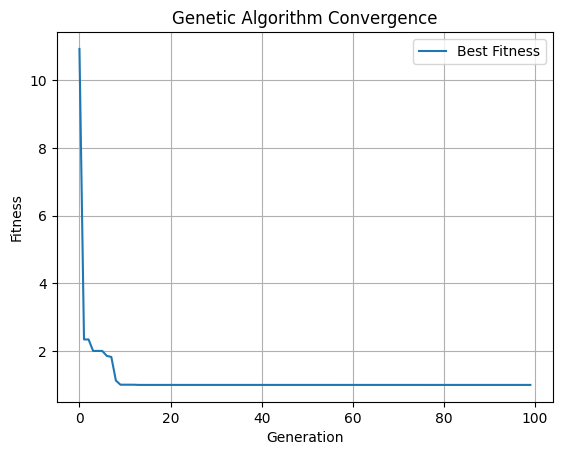

Best solution found by GA: [9.94888415e-01 2.74046536e-04] with fitness: 0.9949749344655707


In [ ]:
ga = GeneticAlgorithm(crossover_rate=0.8, mutation_rate=0.01)
population = initialize_population(ga.pop_size)
fitness_history = []

for gen in range(ga.generations):
    # Evaluate current population
    fitness_vals = np.array([rastrigin(ind) for ind in population])
    inv_fitness = 1 / (fitness_vals + 1e-10)
    
    # Preserve elite (best individual)
    elite_idx = np.argmin(fitness_vals)
    elite = population[elite_idx].copy()
    new_population = []

    for _ in range(ga.pop_size - 1):
        parent1, parent2 = ga.select_parents(population, inv_fitness)
        child = ga.crossover(parent1, parent2)
        child = ga.mutate(child)
        new_population.append(child)

    # Insert elite
    new_population.append(elite)

    # Update population
    population = np.array(new_population)
    best_fit = np.min([rastrigin(ind) for ind in population])
    fitness_history.append(best_fit)
    print(f"Generation {gen+1}: Best Fitness = {best_fit:.6f}")

plot_convergence(fitness_history, "Genetic Algorithm Convergence")
save_fitness_history(fitness_history, "ga_fitness_history.csv")
best_ga =  population[np.argmin([rastrigin(ind) for ind in population])]
print("Best solution found by GA:", best_ga, "with fitness:", rastrigin(best_ga))

In [34]:
class DifferentialEvolution:
    def __init__(self, pop_size=50, generations=100, F=0.5, CR=0.9):
        self.pop_size = pop_size
        self.generations = generations
        self.F = F
        self.CR = CR

    def run_differential_evaluation(self):
        population = initialize_population(self.pop_size)
        fitness_history = []

        for gen in range(self.generations):
            new_population = []
            for i in range(self.pop_size):
                indices = list(range(self.pop_size))
                indices.remove(i)
                r1, r2, r3 = np.random.choice(indices, 3, replace=False)
                x_r1, x_r2, x_r3 = population[r1], population[r2], population[r3]

                mutant = x_r1 + self.F * (x_r2 - x_r3)
                mutant = np.clip(mutant, LOWER_BOUND, UPPER_BOUND)

                trial = np.copy(population[i])
                for d in range(DIMENSIONS):
                    if np.random.rand() < self.CR or d == np.random.randint(DIMENSIONS):
                        trial[d] = mutant[d]

                if rastrigin(trial) < rastrigin(population[i]):
                    new_population.append(trial)
                else:
                    new_population.append(population[i])

            population = np.array(new_population)
            best_fit = np.min([rastrigin(ind) for ind in population])
            fitness_history.append(best_fit)
            print(f"[DE] Generation {gen+1}: Best Fitness = {best_fit:.6f}")

        plot_convergence(fitness_history, "Differential Evolution Convergence")
        save_fitness_history(fitness_history, "de_fitness_history.csv")
        return population[np.argmin([rastrigin(ind) for ind in population])]


[DE] Generation 1: Best Fitness = 10.458128
[DE] Generation 2: Best Fitness = 2.207273
[DE] Generation 3: Best Fitness = 2.207273
[DE] Generation 4: Best Fitness = 2.207273
[DE] Generation 5: Best Fitness = 2.207273
[DE] Generation 6: Best Fitness = 2.207273
[DE] Generation 7: Best Fitness = 2.207273
[DE] Generation 8: Best Fitness = 2.207273
[DE] Generation 9: Best Fitness = 2.207273
[DE] Generation 10: Best Fitness = 0.026714
[DE] Generation 11: Best Fitness = 0.026714
[DE] Generation 12: Best Fitness = 0.026714
[DE] Generation 13: Best Fitness = 0.026714
[DE] Generation 14: Best Fitness = 0.026714
[DE] Generation 15: Best Fitness = 0.026714
[DE] Generation 16: Best Fitness = 0.026714
[DE] Generation 17: Best Fitness = 0.026714
[DE] Generation 18: Best Fitness = 0.026714
[DE] Generation 19: Best Fitness = 0.026714
[DE] Generation 20: Best Fitness = 0.026714
[DE] Generation 21: Best Fitness = 0.026714
[DE] Generation 22: Best Fitness = 0.026714
[DE] Generation 23: Best Fitness = 0.026

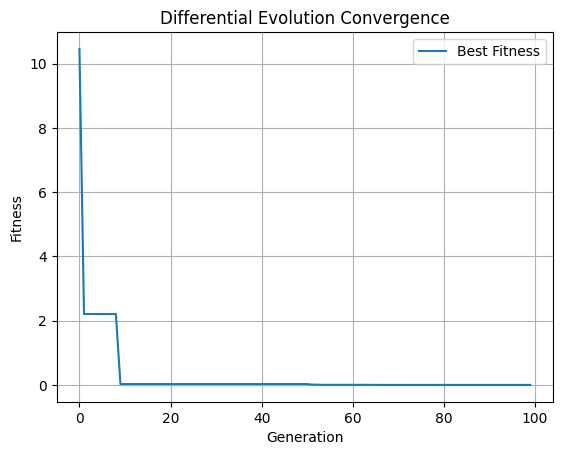

Best solution found by DE: [-2.47965419e-06  2.15176842e-06] with fitness: 2.1384281012615247e-09


In [161]:
de = DifferentialEvolution(F=0.8, CR=0.9)
best_de = de.run_differential_evaluation()
print("Best solution found by DE:", best_de, "with fitness:", rastrigin(best_de))
    

[PSO] Generation 1: Best Fitness = 8.265422
[PSO] Generation 2: Best Fitness = 8.265422
[PSO] Generation 3: Best Fitness = 8.265422
[PSO] Generation 4: Best Fitness = 7.040092
[PSO] Generation 5: Best Fitness = 7.040092
[PSO] Generation 6: Best Fitness = 4.461201
[PSO] Generation 7: Best Fitness = 1.432359
[PSO] Generation 8: Best Fitness = 1.432359
[PSO] Generation 9: Best Fitness = 1.432359
[PSO] Generation 10: Best Fitness = 1.432359
[PSO] Generation 11: Best Fitness = 1.432359
[PSO] Generation 12: Best Fitness = 0.997019
[PSO] Generation 13: Best Fitness = 0.997019
[PSO] Generation 14: Best Fitness = 0.997019
[PSO] Generation 15: Best Fitness = 0.044049
[PSO] Generation 16: Best Fitness = 0.044049
[PSO] Generation 17: Best Fitness = 0.044049
[PSO] Generation 18: Best Fitness = 0.044049
[PSO] Generation 19: Best Fitness = 0.044049
[PSO] Generation 20: Best Fitness = 0.044049
[PSO] Generation 21: Best Fitness = 0.044049
[PSO] Generation 22: Best Fitness = 0.044049
[PSO] Generation 23

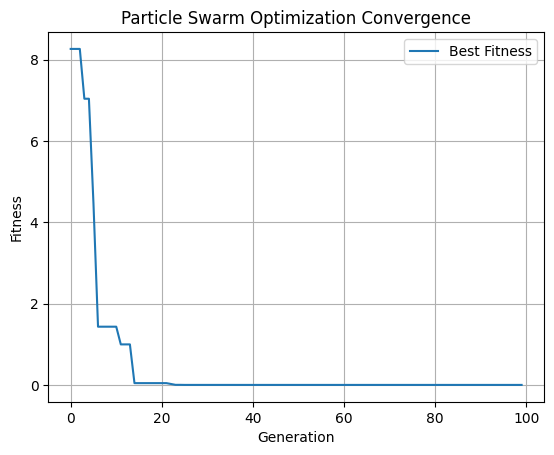

Best solution found by PSO: [ 8.25141742e-11 -8.51345350e-10] with fitness: 0.0


In [198]:
def run_particle_swarm_optimization(pop_size=50, generations=100, w=0.4, c1=1.2, c2=1.2):
    positions = initialize_population(pop_size)
    velocities = np.random.uniform(-1, 1, (pop_size, DIMENSIONS))
    personal_best_positions = np.copy(positions)
    personal_best_scores = np.array([rastrigin(p) for p in positions])
    global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
    global_best_score = np.min(personal_best_scores)
    fitness_history = []

    for gen in range(generations):
        for i in range(pop_size):
            r1, r2 = np.random.rand(DIMENSIONS), np.random.rand(DIMENSIONS)
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (personal_best_positions[i] - positions[i])
                + c2 * r2 * (global_best_position - positions[i])
            )
            positions[i] += velocities[i]
            positions[i] = np.clip(positions[i], LOWER_BOUND, UPPER_BOUND)

            score = rastrigin(positions[i])
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_positions[i] = positions[i]

                if score < global_best_score:
                    global_best_score = score
                    global_best_position = positions[i]

        fitness_history.append(global_best_score)
        print(f"[PSO] Generation {gen+1}: Best Fitness = {global_best_score:.6f}")

    plot_convergence(fitness_history, "Particle Swarm Optimization Convergence")
    save_fitness_history(fitness_history, "pso_fitness_history.csv")
    return global_best_position

best_pso = run_particle_swarm_optimization()
print("Best solution found by PSO:", best_pso, "with fitness:", rastrigin(best_pso))

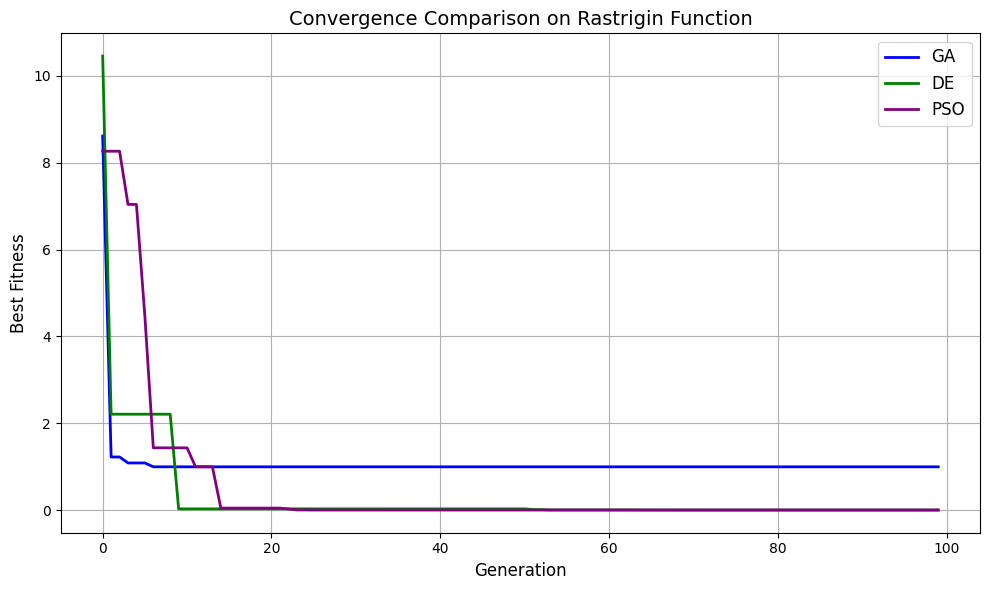

In [199]:
# Combined Plotting
# Load fitness histories
ga_data = pd.read_csv("ga_fitness_history.csv")
de_data = pd.read_csv("de_fitness_history.csv")
pso_data = pd.read_csv("pso_fitness_history.csv")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(ga_data["Generation"], ga_data["BestFitness"], label="GA", color="blue", linewidth=2)
plt.plot(de_data["Generation"], de_data["BestFitness"], label="DE", color="green", linewidth=2)
plt.plot(pso_data["Generation"], pso_data["BestFitness"], label="PSO", color="purple", linewidth=2)

plt.title("Convergence Comparison on Rastrigin Function", fontsize=14)
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Best Fitness", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

# Save and show
plt.savefig("data/convergence_comparison.png", dpi=300)
plt.show()
